In [21]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

In [22]:
items = pd.read_csv('D:/GIT/kaggle_develop/predictSales/input/items.csv')
shops = pd.read_csv('D:/GIT/kaggle_develop/predictSales/input/shops.csv')
cats = pd.read_csv('D:/GIT/kaggle_develop/predictSales/input/item_categories.csv')
train = pd.read_csv('D:/GIT/kaggle_develop/predictSales/input/sales_train_v2.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('D:/GIT/kaggle_develop/predictSales/input/test.csv').set_index('ID')

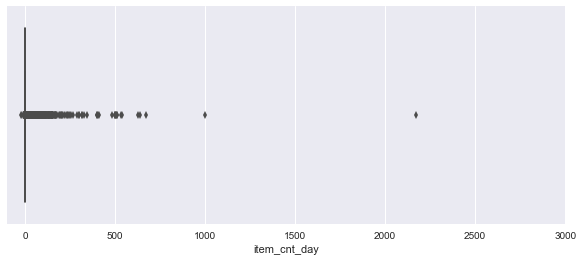

In [23]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

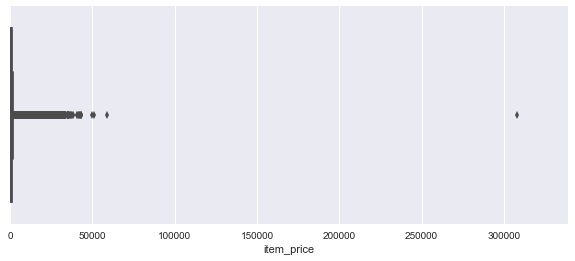

In [24]:
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [25]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [26]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [27]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [28]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [31]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(list(set(test.shop_id))),len(test)

(363, 5100, 42, 214200)

In [30]:
len(list(set(test.shop_id)))

42

In [34]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

11.833183288574219

In [46]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [47]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

5.752575159072876

In [48]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [49]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [50]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [51]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.1070106029510498

In [52]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

6.388638734817505

In [53]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [60]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

47.04199981689453

In [59]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1_x,item_cnt_month_lag_2_x,item_cnt_month_lag_3_x,item_cnt_month_lag_6_x,item_cnt_month_lag_12_x,item_cnt_month_lag_1_y,item_cnt_month_lag_2_y,item_cnt_month_lag_3_y,item_cnt_month_lag_6_y,item_cnt_month_lag_12_y,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.70300006866455

In [62]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1_x,item_cnt_month_lag_2_x,item_cnt_month_lag_3_x,item_cnt_month_lag_6_x,item_cnt_month_lag_12_x,item_cnt_month_lag_1_y,item_cnt_month_lag_2_y,item_cnt_month_lag_3_y,item_cnt_month_lag_6_y,item_cnt_month_lag_12_y,item_cnt_month_lag_1_x,item_cnt_month_lag_2_x,item_cnt_month_lag_3_x,item_cnt_month_lag_6_x,item_cnt_month_lag_12_x,item_cnt_month_lag_1_y,item_cnt_month_lag_2_y,item_cnt_month_lag_3_y,item_cnt_month_lag_6_y,item_cnt_month_lag_12_y,date_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1_x', 'item_cnt_month_lag_2_x',
       'item_cnt_month_lag_3_x', 'item_cnt_month_lag_6_x',
       'item_cnt_month_lag_12_x', 'item_cnt_month_lag_1_y',
       'item_cnt_month_lag_2_y', 'item_cnt_month_lag_3_y',
       'item_cnt_month_lag_6_y', 'item_cnt_month_lag_12_y',
       'item_cnt_month_lag_1_x', 'item_cnt_month_lag_2_x',
       'item_cnt_month_lag_3_x', 'item_cnt_month_lag_6_x',
       'item_cnt_month_lag_12_x', 'item_cnt_month_lag_1_y',
       'item_cnt_month_lag_2_y', 'item_cnt_month_lag_3_y',
       'item_cnt_month_lag_6_y', 'item_cnt_month_lag_12_y',
       'date_avg_item_cnt_lag_1'],
      dtype='object')

In [64]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 29 columns):
date_block_num             int8
shop_id                    int8
item_id                    int16
item_cnt_month             float16
city_code                  int8
item_category_id           int8
type_code                  int8
subtype_code               int8
item_cnt_month_lag_1_x     float16
item_cnt_month_lag_2_x     float16
item_cnt_month_lag_3_x     float16
item_cnt_month_lag_6_x     float16
item_cnt_month_lag_12_x    float16
item_cnt_month_lag_1_y     float16
item_cnt_month_lag_2_y     float16
item_cnt_month_lag_3_y     float16
item_cnt_month_lag_6_y     float16
item_cnt_month_lag_12_y    float16
item_cnt_month_lag_1_x     float16
item_cnt_month_lag_2_x     float16
item_cnt_month_lag_3_x     float16
item_cnt_month_lag_6_x     float16
item_cnt_month_lag_12_x    float16
item_cnt_month_lag_1_y     float16
item_cnt_month_lag_2_y     float16
item_cnt_month_lag_3_y     flo